# DAT102x: Predicting County-Level Rents

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

%matplotlib inline

## Get the data

In [2]:
# get data form the csv 
path = os.path.join("data","train_labels_DPetPH2.csv")
df_labels = pd.read_csv(path)

path = os.path.join("data","train_values_OL27nta.csv")
df_values = pd.read_csv(path)

path = os.path.join("data","test_values_kWyIOM9.csv")
df_test = pd.read_csv(path)
df_test["gross_rent"] = np.nan

# aggregate the data in one big df
df_train = pd.concat([
    df_values,
    df_labels.rename(columns={"row_id": "row_id_copy"}), 
], axis=1, sort=True)
df_train = df_train.drop(columns=["row_id_copy"])

df_all = pd.concat([
    df_train,
    df_test 
], axis=0, sort=True)

df_all.head().transpose()

,0,1,2,3,4
air_pollution_particulate_matter_value,11.0229,9.9041,11.0115,12.8458,11.5658
birth_rate_per_1k,10.009,14.4829,9.62035,9.38322,9.54329
county_code,8e686a7,d1b5fc5,19a463b,1711ab7,1eb4681
death_rate_per_1k,9.75234,3.01322,10.8736,10.8708,14.7239
economic_typology,Manufacturing-dependent,Recreation,Recreation,Nonspecialized,Farm-dependent
evictions,NaN,3,9,0,2
gross_rent,577,844,700,592,444
heart_disease_mortality_per_100k,217,181,234,231,270
homicides_per_100k,NaN,NaN,NaN,NaN,NaN
motor_vehicle_crash_deaths_per_100k,NaN,18.26,19.94,30.31,NaN


## Missing value imputation

In [3]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
imp = IterativeImputer(max_iter=600, random_state=0, 
                       sample_posterior=True, initial_strategy="median",
                       min_value=0, verbose=0)

# excludes target, categorical, useless cols
cols = list(df_all.columns)
cols.remove("county_code")
cols.remove("state")
cols.remove("rucc")
cols.remove("urban_influence")
cols.remove("economic_typology")
cols.remove("gross_rent")

# modify some cols to add some consistency with other features
df_all["renter_occupied_households"] = df_all["renter_occupied_households"] / df_all["population"]
df_all["evictions"] = df_all["evictions"] / df_all["population"]
df_all["pct_white"] = 1-df_all["pct_white"]
df_all["pct_female"] = 1-df_all["pct_female"]

# negative values
df_all.loc[df_all["homicides_per_100k"]<0.0, "homicides_per_100k"] = np.nan
df_all.loc[df_all["evictions"]<0.0, "evictions"] = np.nan

#execute the Imputer
imp.fit(df_all[cols].values)
imputation = imp.transform(df_all[cols])

#re_inject the imputed variables in the df
for i,c in enumerate(cols):
    mask = df_all[c].isna()
    if imputation[mask,i].shape[0]>0:
        df_all.loc[mask, c] = imputation[mask,i]

# just a fix in case the imputer generated negative values
for c in cols:
    df_all.loc[df_all[c]<0.0, c] = 0.0

#re-breakdown the data into train and test (predict) sets
df_test  = df_all.tail(df_test.shape[0])
df_train = df_all.head(df_train.shape[0])
df_test = df_test.drop(columns=["gross_rent"])


## Data pre-processing

In [4]:
from sklearn import preprocessing

def label_encoding(features):
    enc = preprocessing.LabelEncoder()
    enc.fit(features)
    features = enc.transform(features)
    ohe = preprocessing.OneHotEncoder(categories="auto")
    encoded = ohe.fit(features.reshape(-1,1))
    features = encoded.transform(features.reshape(-1,1)).toarray()
    return features, enc.classes_
   
def preprocess(df_tmp, scl):
    
    # are we in the training set ?
    is_training = False
    cols = df_tmp.columns
    if "gross_rent" in cols :
        cols = cols.drop('gross_rent')
        is_training = True
    
    # useless cols
    cols_to_remove = ["row_id", "county_code", "state"]
    for c in cols_to_remove : 
        cols = cols.drop(c)

    # categorical cols
    cols_categorical = ["rucc", "urban_influence", "economic_typology"]
    for c in cols_categorical : 
        cols = cols.drop(c)
        
    #one-hot_encoding
    features_cat, idx_categorical = None, 0
    for c in cols_categorical : 
        data, _ = label_encoding(df_tmp[c])
        if features_cat is None : features_cat = data
        else : features_cat = np.concatenate([features_cat, data], axis=1)
    idx_categorical = features_cat.shape[1]
    
    #log transform skewed cols
    log_cols =['population',
         'renter_occupied_households',
         'pct_renter_occupied',
         'pct_white',
         'pct_female']
    for c in log_cols: df_tmp[c] = np.log(df_tmp[c])
    log_cols =['pct_af_am',
         'pct_hispanic',
         'pct_am_ind',
         'pct_asian',
         'pct_nh_pi',
         'pct_multiple',
         'pct_other',
         'pct_uninsured_children',
         'homicides_per_100k',
         'pct_adults_bachelors_or_higher',
         'pop_per_primary_care_physician',
         'pop_per_dentist',
         'poverty_rate']
    for c in log_cols: df_tmp[c] = np.log(df_tmp[c]+1e-20)

    # get numeric data
    features_numeric = None
    for c in cols:
        data = df_tmp[c].values.reshape(-1,1)
        if features_numeric is None : features_numeric = data
        else : features_numeric = np.concatenate([features_numeric, data], axis=1)

    # scale numeric features
    if is_training : 
        scl = scl.fit(features_numeric)
    features_numeric = scl.transform(features_numeric)

    # aggregate categorical and numeric features
    features = np.concatenate([features_cat, features_numeric], axis=1)
    
    return features, scaler

df_tmp = df_train.copy()
scaler = preprocessing.RobustScaler()

train_features, scaler = preprocess(df_tmp, scaler)
train_labels = df_tmp["gross_rent"].values 
train_labels = train_labels.reshape(-1,1)

## Neural Network model definition 

In [5]:
import torch 
from torch import nn
from torch import optim
import torch.nn.functional as F

class PyTorchNet(nn.Module):
    hidden_1 = 444
    hidden_2 = 444
    hidden_3 = 444
    def __init__(self, input_size=66):
        super(PyTorchNet, self).__init__()
        self.input_size = input_size

        # create all the layers
        self.fc1 = nn.Linear(self.input_size, self.hidden_1, bias=False)
        self.fc2 = nn.Linear(self.hidden_1,   self.hidden_2, bias=False)
        self.fc3 = nn.Linear(self.hidden_2,   self.hidden_3, bias=False)
        self.fo  = nn.Linear(self.hidden_3, 1)

        # create all batch norm layers
        self.bn1 = nn.BatchNorm1d(self.hidden_1)
        self.bn2 = nn.BatchNorm1d(self.hidden_2)
        self.bn3 = nn.BatchNorm1d(self.hidden_3)

        # activation and drop out
        self.activation = F.relu6
        self.dropout = nn.Dropout(p=0.2)

    def forward(self, x):
        # thru all layers 
        x = self.activation(self.fc1(x))
        x = self.bn1(x)
        x = self.dropout(x)
        x = self.activation(self.fc2(x))
        x = self.bn2(x)
        x = self.dropout(x)
        x = self.activation(self.fc3(x))
        x = self.bn3(x)
        x = self.dropout(x)
        x = self.fo(x)    
        return x


In [6]:
import copy
import sklearn.metrics as sklm

# train and return the pytorch model 
def train_pytorch_model(X_train, X_test, y_train, y_test, n_epochs=10_000, verbose=False):
    #creates Tensors
    X_train = torch.Tensor(X_train)
    y_train = torch.Tensor(y_train)
    X_test = torch.Tensor(X_test)
    y_test = torch.Tensor(y_test)

    #init
    model = PyTorchNet(input_size=X_train.shape[1])
    state_dict = model.state_dict()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    best_r2 = -9999.0

    model.cuda()
    X_train = X_train.cuda()
    X_test = X_test.cuda()
    y_train = y_train.cuda()
    y_test = y_test.cuda()

    for epoch in range(int(n_epochs)):
        #training
        model.train()
        optimizer.zero_grad()
        output = model.forward(X_train)
        loss1 = criterion(output, y_train.reshape(-1,1))
        loss1.backward()
        optimizer.step()

        #evaluation
        model.eval()
        with torch.no_grad():
            output = model.forward(X_test)
            loss = criterion(output, y_test.reshape(-1,1))

        #evaluation metrci and model selection
        r2 = sklm.r2_score((y_test.cpu().numpy()), (output.detach().cpu().numpy()))
        if r2>best_r2 : 
            best_r2=r2
            state_dict = copy.deepcopy(model.state_dict())
        
        #verbose
        if verbose and (epoch % 50 == 0 or epoch+1 == n_epochs) :
            print(" "*78,end="\r")
            print(epoch,best_r2,end="\r")

    # retrieve best model
    model.load_state_dict(state_dict)
    model.cpu()
    model.eval()
    return model

In [7]:
# # test model
# import sklearn.model_selection as ms
# import numpy.random as nr

# nr.seed(42)
# indx = range(train_features.shape[0])
# indx = ms.train_test_split(indx, test_size = 0.2)
# X_train = train_features[indx[0],:]
# y_train = np.ravel(train_labels[indx[0]])
# X_test = train_features[indx[1],:]
# y_test = np.ravel(train_labels[indx[1]])

# test_model = train_pytorch_model(X_train, X_test, y_train, y_test, n_epochs=300)


## Stacked model (PyTorch neural network + a set of sklearn style models)

In [8]:
# inspired by https://www.kaggle.com/serigne/stacked-regressions-top-4-on-leaderboard
import numpy.random as nr
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone
from sklearn.model_selection import KFold #, cross_val_score, train_test_split

class StackedModels(BaseEstimator, RegressorMixin, TransformerMixin):

    def __init__(self, base_models, meta_model, n_folds=10):
        self.base_models = base_models
        self.n_folds = n_folds
        self.meta_model = meta_model
        self.__models = [[None]*(len(self.base_models)+1)]*n_folds
        self.__scores = [[-999]*(len(self.base_models)+1)]*n_folds
   
    # build all the models : PyTorch, base models, meta model
    def fit(self, X, y, n_epochs=10_000, n_try=3, verbose=False):
        self.__meta_model  = clone(self.meta_model)
        
        # where we store our intermediary predition
        stacked_y = np.zeros((X.shape[0], (len(self.base_models)+1)))
        model_name = ""
        
        # Train the pytorch model on a first sets of folds
        # keep the eval prediction for the meta model
        nr.seed(42)
        kfold = KFold(n_splits=self.n_folds, shuffle=True)
        for i, (train_index, eval_index) in enumerate(kfold.split(X, y)):
            X_train, X_eval = X[train_index], X[eval_index]
            y_train, y_eval = y[train_index], y[eval_index]
            r2_memo = 0
            for _ in range(n_try):
                m = train_pytorch_model(X_train, X_eval, y_train, y_eval, 
                                        n_epochs=n_epochs, verbose=verbose)
                with torch.no_grad():
                    y_out = m.forward(torch.Tensor(X_eval)).numpy()
                r2 = sklm.r2_score((y_eval), (y_out))
                if verbose: 
                    if type(m) != model_name : 
                        model_name = type(m)
                        print(model_name)
                    print(i, r2)
                if r2 > r2_memo :
                    r2_memo = r2
                    self.__models[i][0] = m
                    self.__scores[i][0] = r2 
                    stacked_y[eval_index, 0] = y_out.ravel()

        # Train all the sklearn type models on a different sets of folds
        # keep the eval prediction for the meta model
        for bmodel_idx in range(len(self.base_models)):
            nr.seed(42+bmodel_idx+1)
            kfold = KFold(n_splits=self.n_folds, shuffle=True)
            for i, (train_index, eval_index) in enumerate(kfold.split(X, y)):
                X_train, X_eval = X[train_index], X[eval_index]
                y_train, y_eval = y[train_index], y[eval_index]
                m = clone(self.base_models[bmodel_idx])
                m.fit(X_train, y_train)
                y_out = m.predict(X_eval)
                r2 = sklm.r2_score((y_eval), (y_out))
                if verbose : 
                    if type(m) != model_name : 
                        model_name = type(m)
                        print(model_name)
                    print(i, r2)
                self.__models[i][bmodel_idx+1] = m
                self.__scores[i][bmodel_idx+1] = r2 
                stacked_y[eval_index, bmodel_idx+1] = y_out.ravel()
          
        # fit the meta model using all the eval prediction 
        self.__meta_model.fit(stacked_y, y)
        if verbose :
            print(type(self.__meta_model))
            print([e for e in self.__meta_model.named_steps.keys()])
            if "lasso" in self.__meta_model.named_steps.keys():
                print(self.__meta_model["lasso"].coef_)
            print(np.mean(self.__scores), np.std(self.__scores))

        return self
   
    # perform the prediction for X
    def predict(self, X):
        X_torch = torch.Tensor(X)
        stacked_pred = np.zeros((X.shape[0], (len(self.base_models)+1)))
        # adding the prediction for each fold
        for i in range(self.n_folds):
            with torch.no_grad():
                p = self.__models[i][0].forward(X_torch).cpu().numpy().ravel()
                stacked_pred[:,0] = stacked_pred[:,0]+p
            for j in range(len(self.base_models)):
                p = self.__models[i][j+1].predict(X)
                stacked_pred[:,j+1] = stacked_pred[:,j+1]+p
        # averaging for each model
        stacked_pred = stacked_pred / self.n_folds

        # lastly use the meta model 
        return self.__meta_model.predict(stacked_pred)


## Building and training the stacked model 

In [9]:
p_XGBt = {'base_score': 0.5,
 'booster': 'gbtree',
 'colsample_bylevel': 1,
 'colsample_bynode': 1,
 'colsample_bytree': 0.9,
 'gamma': 0,
 'importance_type': 'gain',
 'learning_rate': 0.05,
 'max_delta_step': 0,
 'max_depth': 4,
 'min_child_weight': 1,
 'missing': None,
 'n_estimators': 900,
 'n_jobs': 1,
 'nthread': None,
 'objective': 'reg:squarederror',
 'random_state': 0,
 'reg_alpha': 0,
 'reg_lambda': 0.9,
 'scale_pos_weight': 1,
 'seed': None,
 'silent': None,
 'subsample': 0.8,
 'verbosity': 1}

p_CatBt = {'verbose': 0,
 'loss_function': 'RMSE',
 'depth': 5,
 'learning_rate': 0.09,
 'iterations': 900}

In [10]:
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import Lasso

XGBt  = XGBRegressor(**p_XGBt)
CatBt = CatBoostRegressor(**p_CatBt)
lasso = make_pipeline(preprocessing.RobustScaler(), 
                      Lasso(alpha =0.0065, random_state=1))

model = StackedModels((XGBt, CatBt), meta_model=lasso, n_folds=10)


In [11]:
# # test model
# import sklearn.model_selection as ms
# import numpy.random as nr
# test_model = StackedModels((XGBt, CatBt), meta_model=lasso, n_folds=3)
# nr.seed(42)
# indx = range(train_features.shape[0])
# indx = ms.train_test_split(indx, test_size = 0.2)
# X_train = train_features[indx[0],:]
# y_train = np.ravel(train_labels[indx[0]])
# X_test = train_features[indx[1],:]
# y_test = np.ravel(train_labels[indx[1]])
# test_model = test_model.fit(X_train, y_train, n_epochs=2_000, n_try=2, verbose=True)
# y_score = test_model.predict(X_test)
# r2 = sklm.r2_score(y_test, y_score)
# r2

In [12]:
model = StackedModels((XGBt, CatBt), meta_model=lasso, n_folds=10)
model = model.fit(train_features, train_labels, n_epochs=10_000, n_try=3, verbose=True)

<class '__main__.PyTorchNet'>                                                 
0 0.8168233565188696
0 0.820893360959027133                                                        
0 0.834156388740099937                                                        
1 0.8916843011721205605                                                       
1 0.8835789100864648489                                                       
1 0.8923896946667907508                                                       
2 0.7651112080721072398                                                       
2 0.7925320970364704005                                                       
2 0.8146316409727682147                                                       
3 0.7917417575456556668                                                       
3 0.7926370153222737099                                                       
3 0.7954786302781572969                                                       
4 0.7859756364344949621        

## Prediction 

In [13]:
# generate the submission csv file
test_features, *_ = preprocess(df_test.copy(), scaler)
prediction = model.predict(test_features)
prediction = np.rint(prediction)
df_pred = pd.DataFrame(prediction.astype("int32"))
df_pred.index = df_pred.index.rename("row_id")
df_pred = df_pred.rename(columns={0 : "gross_rent"})
path = os.path.join("submission","prediction.csv")
df_pred.to_csv(path)

In [14]:
# quick check
df_pred

,gross_rent
row_id,
0,606
1,976
2,730
3,782
4,968
...,...
1571,596
1572,574
1573,1179


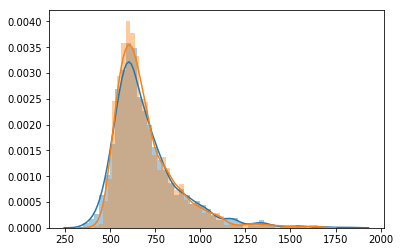

In [20]:
# prediction vs. target distribution 
import seaborn as sns

v1 = train_labels
v2 = df_pred["gross_rent"].values
sns.distplot(tuple(v1), bins=50)
sns.distplot(tuple(v2), bins=50)
plt.show()


-2224


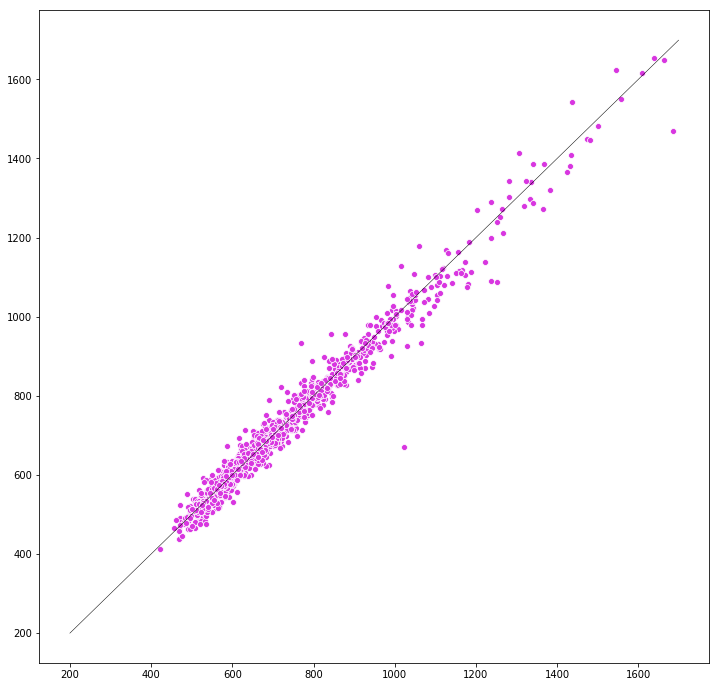

In [21]:
# compare to best prediction #191
path = os.path.join("submission","result_191.csv")
df_values = pd.read_csv(path)
v1 = df_values["gross_rent"].values

print(np.sum(v2-v1))
    
fig, ax = plt.subplots(figsize=(12,12))
ax = fig.add_subplot()
sns.scatterplot(v1, v2, c=np.random.rand(3,))
plt.plot(range(200,1700), range(200,1700), c='black', lw=0.5)
